## Sentinel-1 Land Change Detection

In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio.features

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer as pc

# Other tools
from scipy.ndimage import uniform_filter, variance
from PIL import Image
import odc
from odc.stac import stac_load

### Define the analysis region and load the data

In [2]:
# Camp Fire, Paradise, CA
# Time = 2018-10-01, 2018-11-30
# Fire started 11-08, contained 11-25
# Compare scenes 0 to 8 for best results

# ll = (39.7375, -121.5599)
# ur = (39.8464, -121.4408)
# time_of_interest = ('2018-11-01', '2018-12-31')

# Lake Berryessa, Napa, CA
# Time = 2020-07-01, 2020-09-01
# Fire started 08-16-20
# Compare scenes 2 and 8 for best results

# ll = (38.45, -122.278)
# ur = (38.55, -122.178)
# time_of_interest = ('2020-08-01', '2020-08-31')

# Fiji - Vanua Levu Island (storm damage)

# Large Region
# ll = (-17.0886, 178.4086)
# ur = (-16.3743, 179.1545)

# Smaller Region
ll = (-16.7019, 178.7660)
ur = (-16.5873, 178.8550)
time_of_interest = "2020-11-01/2020-11-30"

In [3]:
bbox = [ll[1], ll[0], ur[1], ur[0]]

Using the `pystac_client` we can search the Planetary Computer's STAC endpoint for items matching our query parameters. The result is the number of scenes matching our search criteria that touch our area of interest. Some of these may be partial scenes. 

In [4]:
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

In [5]:
# We will only load a specific orbit path (descending or ascending)

search = catalog.search(
    collections=["sentinel-1-rtc"], 
    bbox=bbox, 
    datetime=time_of_interest,
    query={"sat:orbit_state": {"eq": "descending"}}
)

In [6]:
items = list(search.get_all_items()) # This produces a list of scene IDs

In [7]:
print('This is the number of scenes that touch our region:',len(items))

This is the number of scenes that touch our region: 3


Next, we'll load the data into an XARRAY and then "clip" the data to only the pixels within our region (bounding box). We will only keep the desired bands (VV, VH). We have changed the projection to epsg=4326 which is standard latitude-longitude in degrees and we have specified the spatial resolution of each pixel to be 10-meters, which is the baseline accuracy for this data. 

In [8]:
# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
# The best resolution for Sentinel-1 is 10-meters
# Use 100-meters for rapid review of the datasets

resolution = 20  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for crs=4326 

In [9]:
# Load the data using Open Data Cube

data = stac_load(
    items,bands=["vv", "vh"], 
    patch_url=pc.sign, 
    bbox=bbox, 
    crs="EPSG:4326", 
    resolution=scale, 
    groupby="solar_day"
)

In [10]:
# View the details of our xarray dataset
# The X and Y dimensions tell us the pixel dimensions of our bounding box
# The "time" variable is the number of scenes that touch our region
data

<xarray.Dataset> Size: 8MB
Dimensions:      (latitude: 639, longitude: 496, time: 3)
Coordinates:
  * latitude     (latitude) float64 5kB -16.59 -16.59 -16.59 ... -16.7 -16.7
  * longitude    (longitude) float64 4kB 178.8 178.8 178.8 ... 178.9 178.9 178.9
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 24B 2020-11-05T17:40:45.734793 ... 202...
Data variables:
    vv           (time, latitude, longitude) float32 4MB 0.02377 ... 0.1141
    vh           (time, latitude, longitude) float32 4MB 0.006204 ... 0.04014

In [11]:
# Adjust band data for improved RGB output
vv_new = data.vv / 6
vh_new = data.vh / 1
data['vv_new'] = vv_new
data['vh_new'] = vh_new
data['vvvh_new'] = (vv_new / vh_new) / 30

### View RGB (false color) images from the time series

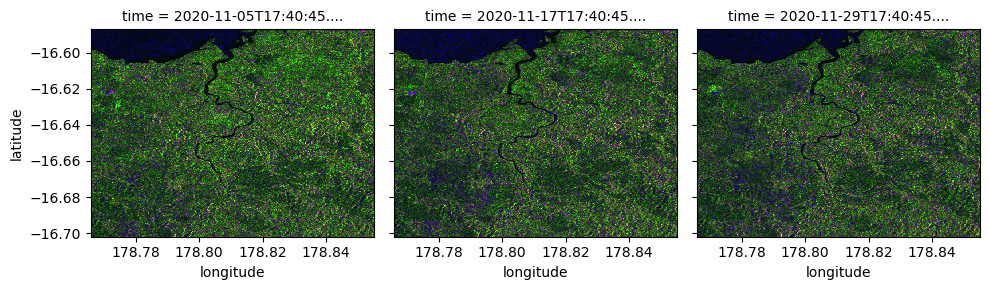

In [12]:
# Plot small images for the entire dataset
# CAUTION ... This can produce lots of images in a large time series

plot_data = data[["vv_new","vh_new","vvvh_new"]].to_array()
plot_data.plot.imshow(col='time', col_wrap=3, vmin=0.0, vmax=0.15)
plt.show()

In [13]:
# Select a time slice to view a single scene
# See the XARRAY dimensions above for the number of time slices (starts at 0)
slice = 0

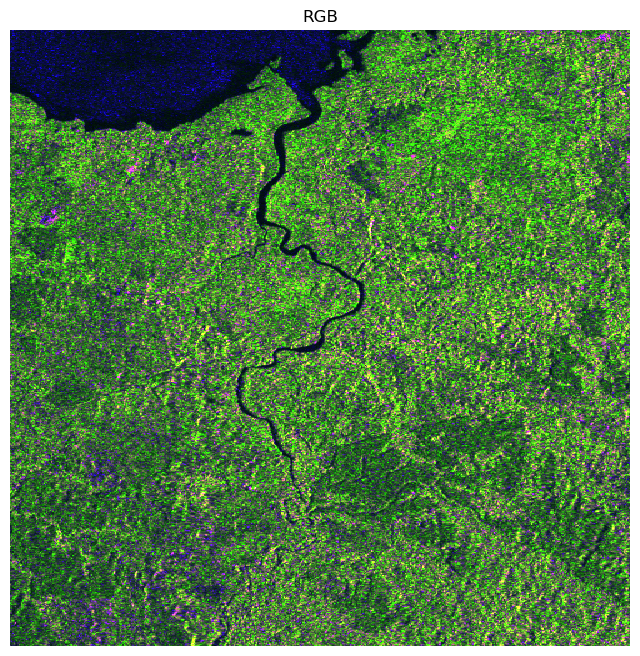

In [14]:
fig, ax = plt.subplots(figsize=(8,8))
plot_data.isel(time=slice).plot.imshow(robust=True, ax=ax, vmin=0.0, vmax=0.1)
plt.title("RGB")
plt.axis('off')
plt.show()

### Speckle Filtering using a Lee Filter
Radar data is often "grainy" in appearance and differences between water and land are not consistent. To improve the data, it is quite common to use speckle filtering. Below is an algorithm that uses a common Lee filter to average the pixels surrounding any given pixel.

In [15]:
def lee_filter(da, size):
    """
    Apply lee filter of specified window size.
    Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python

    """
    da_notime = da.squeeze()
    img = da_notime.values
    img_mean = uniform_filter(img, size)
    img_sqr_mean = uniform_filter(img**2, size)
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)

    # Convert numpy array back to xarray, flipping the Y axis
    output = xr.DataArray(img_output, dims=da_notime.dims, coords=da_notime.coords)
    
    return output

In [16]:
# The lee filter above doesn't handle null values
# We therefore set null values to 0 before applying the filter
valid = np.isfinite(data)
masked = data.where(valid, 0)

# Create a new entry in dataset corresponding to filtered VV and VH data
# Select the filter size at the end of each line ... use odd numbers (3,5,7, etc).
data["filtered_vv"] = masked.vv.groupby("time").map(lee_filter, size=5)
data["filtered_vh"] = masked.vh.groupby("time").map(lee_filter, size=5)

# Null pixels should remain null
data['filtered_vv'] = data.filtered_vv.where(valid.vv)
data['filtered_vh'] = data.filtered_vh.where(valid.vh)

### Convert the digital numbers to dB
While Sentinel-1 backscatter is provided as linear intensity, it is often useful to convert the backscatter to decible (dB) for an

In [17]:
data['filtered_vv'] = 10 * np.log10(data.filtered_vv)
data['filtered_vh'] = 10 * np.log10(data.filtered_vh)

## View Histogram Plots
Histogram plots are good for viewing the statistical backscatter distribution of the VV and VH data. In most cases it is easy to identify the difference between land pixels (higher values) and water pixels (lower values). VV-polarised backscatter may however sometimes be affected by wind and rain effects (which may cause a backscatter increase) which is why the VH polarisation channel is recommended for detection of water. The VH histogram in the example below will typically show land at a peak between -10dB and -15dB and a water (dark) peak between -20dB and -25dB. A reasonable threshold for water detection may be estimated from this histogram. 

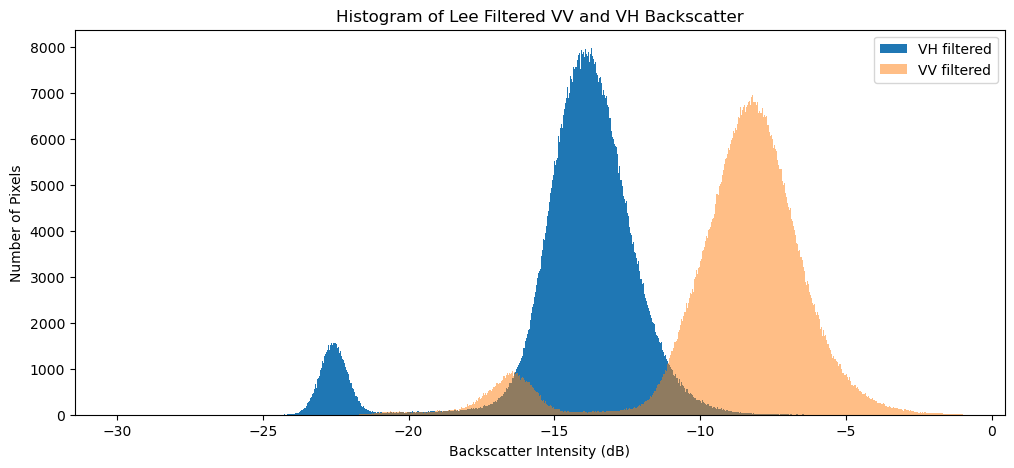

In [18]:
fig = plt.figure(figsize=(12, 5))
data.filtered_vh.plot.hist(bins=1000, range=(-30,-1), label="VH filtered")
data.filtered_vv.plot.hist(bins=1000, range=(-30,-1), label="VV filtered",alpha=0.5)
plt.legend()
plt.xlabel("Backscatter Intensity (dB)")
plt.ylabel("Number of Pixels")
plt.title("Histogram of Lee Filtered VV and VH Backscatter");

## Multi-Date Single-Band Threshold Land Change Product
The code below selects two dates, a variable (VV or VH) and a threshold range. The final product performs a comparison of the two dates and calculates the change in backscatter between those dates. Pixels with significant reduction in backscatter (e.g., loss of 7 dB) are likely changes from land to water due to flooding. Pixels with significant increases in backscatter (e.g., increase of 7 dB) are likely changes from water to land due to drying or drought.

In [19]:
data

<xarray.Dataset> Size: 27MB
Dimensions:      (latitude: 639, longitude: 496, time: 3)
Coordinates:
  * latitude     (latitude) float64 5kB -16.59 -16.59 -16.59 ... -16.7 -16.7
  * longitude    (longitude) float64 4kB 178.8 178.8 178.8 ... 178.9 178.9 178.9
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 24B 2020-11-05T17:40:45.734793 ... 202...
Data variables:
    vv           (time, latitude, longitude) float32 4MB 0.02377 ... 0.1141
    vh           (time, latitude, longitude) float32 4MB 0.006204 ... 0.04014
    vv_new       (time, latitude, longitude) float32 4MB 0.003961 ... 0.01902
    vh_new       (time, latitude, longitude) float32 4MB 0.006204 ... 0.04014
    vvvh_new     (time, latitude, longitude) float32 4MB 0.02128 ... 0.0158
    filtered_vv  (time, latitude, longitude) float32 4MB -15.24 ... -7.821
    filtered_vh  (time, latitude, longitude) float32 4MB -22.41 ... -13.29

In [20]:
# MODIFY HERE

# Select TWO acquisitions to calculate a change product
# Choose from the indices in the table above
# first_acq_ind = First time slice acquisition
# second_acq_ind = Second time slice acquisition

# Pick scenes that are separated by multiples of 12 days
# For example: 12, 24, 36, etc.
# This will ensure consistent viewing geometries for comparisons

first_acq_ind = 0
second_acq_ind = 2

# Select the variable to plot: vv or vh

threshold_variable = 'filtered_vh'

# The code will calculate the difference of the two images (Second-First)
# Define a threshold range to compare the difference of the two acquisitions
# GREY = Pixels NOT in the threshold range 
# RED = Pixels LESS than the low end of the threshold range
# GREEN = Pixels MORE than the high end of the threshold range
# Baseline range is (-4,7) but this can be varied

threshold_range = (-3, 7)

In [21]:
# Set the overlay colors
# Calculate the difference in backscatter between the two times
# Find the pixels above or below the threshold range (these are significant changes)

color_loss = np.array([255,0,0]) # backscatter decrease (RED)
color_gain = np.array([0,255,0]) # backscatter increase (GREEN)
color_black = np.array([0,0,0]) # low backscatter change, water (BLACK)

first_acq = data.isel(time=first_acq_ind)
second_acq = data.isel(time=second_acq_ind)
change_product = second_acq[threshold_variable] - first_acq[threshold_variable]

below_th = change_product.values < threshold_range[0]
above_th = threshold_range[1] < change_product.values

In [22]:
# Set the water threshold value based on data in the histograms for the selected band
# This will "mask" the water pixels and not show false change

water = first_acq[threshold_variable].values < -20.0

In [23]:
def normalize(im):
   # Normalise image to range 0..1
    min, max = im.min(), im.max()
    return (im.astype(float)-min)/(max-min)

# Load images as single channel Numpy arrays
im1 = data["vv_new"].isel(time=0)
im2 = data["vh_new"].isel(time=0)
im3 = data["vvvh_new"].isel(time=0)

# Normalize and scale
n1 = normalize(im1) * 255.999 
n2 = normalize(im2) * 255.999 
n3 = normalize(im3) * 255.999 

brightness_factor = 100 # Adjust as needed
bn1 = np.clip(n1 + brightness_factor, 0, 255).astype(np.uint8)
bn2 = np.clip(n2 + brightness_factor, 0, 255).astype(np.uint8)
bn3 = np.clip(n3 + brightness_factor, 0, 255).astype(np.uint8)

# Merge channels to RGB
# We will use the VH band grey-scale image for the background
result = np.stack([bn2, bn2, bn2], axis=-1) 

In [24]:
paint_on_mask=[(below_th, color_loss),(above_th, color_gain),(water, color_black)]

In [25]:
for mask, color in paint_on_mask:        
        result[mask] = np.array(color)

In [26]:
result = Image.fromarray(result.astype(np.uint8))

### Land Change Product
This is a land change product that reflect loss of vegetation (RED) and gain of vegetation (GREEN) comparing two time steps. Water pixels have been masked with BLACK. 


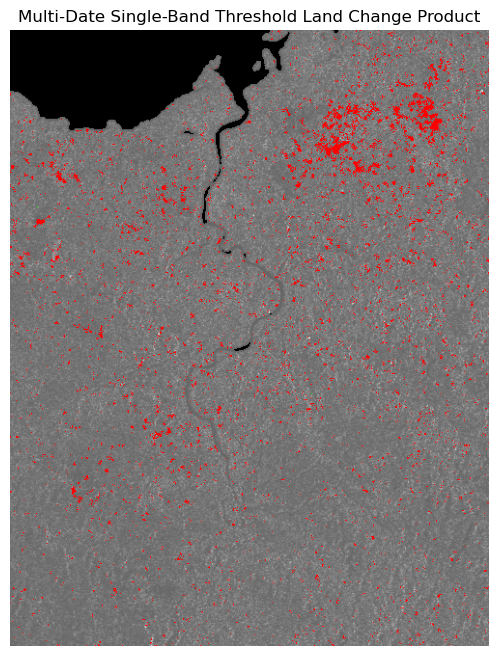

In [27]:
plt.figure(figsize=(8,8))
plt.imshow(result)
plt.title('Multi-Date Single-Band Threshold Land Change Product')
plt.axis('off') 
plt.show()